In [1]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
from scipy.interpolate import interp1d
from scipy.stats import spearmanr
from statsmodels.discrete.discrete_model import Logit
from statsmodels.tools import add_constant
import seaborn as sns
#from utils.roc_functions import resample, empirical_ci, plot_comparison, plot_precision_recall, plot_roc
#from gpcr_mapper.plot_gpcr_mapper import plot_gpcr_mapper
import statsmodels as sm
import statsmodels.formula.api as smf
from scipy.spatial.distance import cdist
from scipy.stats import ttest_ind
import ptitprince as pt

In [18]:
constraint = pd.read_csv('../data/constraint/zscores_hgnc_iuphar.tsv',sep='\t',index_col=0)
constraint = constraint.fillna(0)
constraint['is_gpcr'] = constraint.target_class == 'gpcr'
constraint['mouse_lethal'] = constraint.mouse_lethal.astype(int)
constraint['clinvar_pathogenic'] = constraint.clinvar_pathogenic.astype(int)
constraint['z_max'] = constraint[['z_lof','z_mis_pphen']].max(axis=1)
constraint.columns

curated_essential_gpcrs = pd.read_csv('../data/phenotypes/gpcr_mouse_human_curated_genes.txt',sep='\t')
curated_essential_gpcrs['is_essential_gpcr'] = curated_essential_gpcrs.combined_phenotype.isin(['Lethal','Developmental'])
curated_essential_gpcrs = curated_essential_gpcrs.rename(columns={'gene':'hgnc_symbol'})
curated_essential_gpcrs = curated_essential_gpcrs[['hgnc_symbol','is_essential_gpcr']]
constraint = constraint.merge(curated_essential_gpcrs, on='hgnc_symbol',how='left')
constraint['is_essential_gpcr'] = constraint.is_essential_gpcr.fillna(False).astype(int)

constraint = constraint[constraint.hgnc_symbol!='TTN'] # Remove outlier for cds_length

constraint_gpcrs_bg = constraint[constraint.is_gpcr | (constraint.mouse_lethal==0)]
constraint_gpcrs_only = constraint[constraint.is_gpcr]



constraint_gpcrs_curated_background = constraint[(constraint.is_essential_gpcr==1) | (constraint.mouse_lethal==0)]

constraint.is_essential_gpcr.sum()

86

In [3]:
constraint_gpcrs_bg.shape

(14908, 31)

In [4]:
constraint_gpcrs_curated_background.shape

(14899, 31)

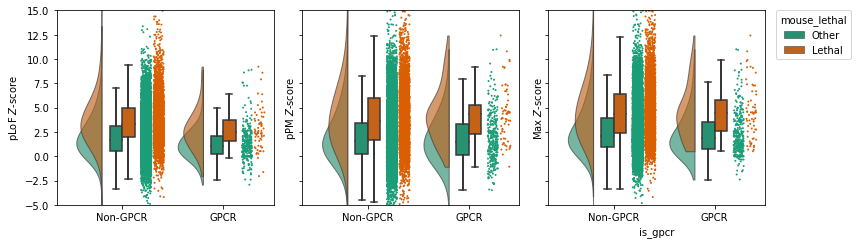

In [14]:
fig, ax = plt.subplots(1, 3, figsize = (12, 3.5),sharey=True,sharex=True)
rc_params = dict(dodge = True,
    point_size = 2,
    point_jitter = 2,
    width_viol = 0.5,
    width_box = 0.25,
    alpha = 0.65,
    box_saturation=0.8,
    box_fliersize=0,
    move=0.3,
    palette='Dark2',
    bw = 0.5)
constraint['mouse_lethal'] = constraint.mouse_lethal.map({1:'Lethal',0:'Other'})
pt.RainCloud(
    data = constraint,
    x = 'is_gpcr',
    y = 'z_lof',
    hue = 'mouse_lethal',
    ax = ax[0],
    **rc_params
)
    
pt.RainCloud(
    data = constraint,
    x = 'is_gpcr',
    y = 'z_mis_pphen',
    hue = 'mouse_lethal',
    ax = ax[1],
    **rc_params
)
pt.RainCloud(
    data = constraint,
    x = 'is_gpcr',
    y = 'z_max',
    hue = 'mouse_lethal',
    ax = ax[2],
    **rc_params
)

ax[0].get_legend().remove()
ax[1].get_legend().remove()
ax[1].set_xlim((-0.65, 1.5))
ax[1].set_ylim((-5, 15))
ax[1].set_xticks([False,True],['Non-GPCR','GPCR'])
ax[0].set_ylabel(r'pLoF $Z$-score')
ax[1].set_ylabel(r'pPM $Z$-score')
ax[2].set_ylabel(r'Max $Z$-score')
ax[0].set_xlabel('')
ax[1].set_xlabel('')
#ax[1].legend(loc='upper right')
plt.tight_layout()

plt.savefig('../plots/iuphar_gpcr_constraint.svg',format='svg')

Compare adjusted/unadjusted classification performance for Z scores

In [7]:
formulae = [
    'mouse_lethal ~ \
    z_lof * num_coding_exons + z_lof * cds_length + z_lof',
    'mouse_lethal ~ \
    z_mis_pphen * num_coding_exons + z_mis_pphen * cds_length + z_mis_pphen',
    'mouse_lethal ~ \
    z_max * num_coding_exons + z_max * cds_length + z_max',
    'mouse_lethal ~ z_lof',
    'mouse_lethal ~ z_mis_pphen',
    'mouse_lethal ~ z_max'
    ]
labels = [
    'adj_lof','unadj_mis_pphen','adj_max',
    'unadj_lof','unadj_mis_pphen','unadj_max'
    ]
models = []
model_scores = []

for formula, label in zip(formulae, labels):
    model = smf.logit(formula, constraint.fillna(0))
    model_fit = model.fit()
    print(model_fit.summary())
    model_scores.append(dict(
        model = label,
        auroc_adj = roc_auc_score(constraint.mouse_lethal, model_fit.predict()),
        auroc_gpcrs_background = roc_auc_score(
            constraint_gpcrs_bg.mouse_lethal, 
            model_fit.predict(constraint_gpcrs_bg)),
        auroc_gpcrs_essential = roc_auc_score(
            constraint_gpcrs_curated_background.is_essential_gpcr,
            model_fit.predict(constraint_gpcrs_curated_background)),
        auroc_gpcrs_only = roc_auc_score(
            constraint_gpcrs_only.mouse_lethal,
            model_fit.predict(constraint_gpcrs_only)),
        auroc_gpcrs_essential_only = roc_auc_score(
            constraint_gpcrs_only.is_essential_gpcr,
            model_fit.predict(constraint_gpcrs_only)),
        auprc_full = average_precision_score(constraint.mouse_lethal, model_fit.predict()),
        bic = model_fit.bic
        ))
model_scores = pd.DataFrame(model_scores)
model_scores.to_csv('../results/mouse_lethal_prediction_scores.tsv',sep='\t',index=False)

Optimization terminated successfully.
         Current function value: 0.476498
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:           mouse_lethal   No. Observations:                18951
Model:                          Logit   Df Residuals:                    18945
Method:                           MLE   Df Model:                            5
Date:                Fri, 09 Jun 2023   Pseudo R-squ.:                 0.08855
Time:                        15:04:52   Log-Likelihood:                -9030.1
converged:                       True   LL-Null:                       -9907.4
Covariance Type:            nonrobust   LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -2.1841      0.040    -54.932      0.000      -2.262      

In [8]:
model_scores.set_index('model').T

model,adj_lof,unadj_mis_pphen,adj_max,unadj_lof,unadj_mis_pphen,unadj_max
auroc_adj,0.711713,0.696518,0.712170,0.709896,0.687171,0.710979
auroc_gpcrs_background,0.590466,0.707833,0.677667,0.619974,0.735848,0.705272
auroc_gpcrs_essential,0.589415,0.688793,0.668614,0.620983,0.706691,0.692322
auroc_gpcrs_only,0.730083,0.762367,0.756402,0.728663,0.755503,0.749633
auroc_gpcrs_essential_only,0.749350,0.757229,0.766409,0.749732,0.734968,0.750727
auprc_full,0.396742,0.388623,0.402480,0.393270,0.385950,0.402629
bic,18119.336594,18334.710690,18090.064547,18179.158510,18437.612764,18107.305116


In [30]:
constraint_gpcrs_only[(constraint_gpcrs_only.is_essential_gpcr==1) & (constraint_gpcrs_only.receptor_)].sort_values('z_max',ascending=False)[['hgnc_symbol','z_lof','z_mis_pphen']].head(20)

,hgnc_symbol,z_lof,z_mis_pphen
2752,CELSR3,9.216540,12.420319
5883,GABBR1,6.454341,10.788016
2197,CASR,4.498895,9.906491
6558,GRM1,4.826993,9.781661
5860,FZD5,3.846784,9.211388
5857,FZD2,3.318667,9.147353
5884,GABBR2,6.374699,9.090334
348,ADGRV1,8.834327,3.018485
2750,CELSR1,8.599436,6.877146
2988,CHRM4,3.359018,7.984783


In [24]:
constraint.columns

Index(['hgnc_symbol', 'hgnc_name', 'transcript', 'cds_length',
       'num_coding_exons', 'obs_syn', 'exp_syn', 'obs_mis', 'exp_mis',
       'obs_lof', 'exp_lof', 'obs_mis_pphen', 'exp_mis_pphen', 'z_syn',
       'oeuf_syn', 'z_mis', 'oeuf_mis', 'z_lof', 'oeuf_lof', 'z_mis_pphen',
       'oeuf_mis_pphen', 'rvis_score', 'phylop_score', 'phylop_score_primate',
       'mouse_lethal', 'clinvar_pathogenic', 'target_class', 'target_family',
       'is_gpcr', 'z_max', 'is_essential_gpcr'],
      dtype='object')

In [23]:
constraint[constraint.hgnc_symbol.str.startswith('CHRM')][['hgnc_symbol','z_lof','z_mis_pphen','z_max','mouse_lethal','is_essential_gpcr']]

,hgnc_symbol,z_lof,z_mis_pphen,z_max,mouse_lethal,is_essential_gpcr
2985,CHRM1,3.741791,6.478301,6.478301,0,0
2986,CHRM2,2.372687,6.925177,6.925177,0,1
2987,CHRM3,4.133707,7.376015,7.376015,0,1
2988,CHRM4,3.359018,7.984783,7.984783,0,1
2989,CHRM5,2.543463,4.470582,4.470582,0,0


In [ ]:
for target_class in constraint.target_class.unique():
    constraint_target

# Count essential genes by family

In [ ]:
gpcr_genes = pd.read_csv('../data/labels/gene_families/gpcr_genes_human_gpcrdb.tsv',sep='\t')
gpcr_mouse_phenotypes_curated = pd.read_csv('../data/labels/curated_essential_genes/gpcr_mouse_human_curated_genes.txt',sep='\t')
gpcr_genes_with_essentiality = gpcr_genes.merge(gpcr_mouse_phenotypes_curated)
essential_gpcr_genes = gpcr_genes_with_essentiality[gpcr_genes_with_essentiality.combined_phenotype.isin(['Lethal','Developmental'])]

print(gpcr_genes_with_essentiality.receptor_class.value_counts())
print(essential_gpcr_genes.receptor_class.value_counts())

# print(gpcr_genes_with_essentiality.receptor_family.value_counts())
# print(essential_gpcr_genes.receptor_family.value_counts())


Class A (Rhodopsin)    282
Class B2 (Adhesion)     32
Class T (Taste 2)       24
Class C (Glutamate)     22
Class B1 (Secretin)     15
Class F (Frizzled)      11
Other GPCRs              5
Name: receptor_class, dtype: int64
Class A (Rhodopsin)    52
Class B2 (Adhesion)    11
Class B1 (Secretin)     9
Class F (Frizzled)      8
Class C (Glutamate)     5
Other GPCRs             1
Name: receptor_class, dtype: int64
